In [ ]:
import os
from pathlib import Path
import random
import yaml
import json
import math
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import torchvision.transforms as T

random.seed(42)
np.random.seed(42)

In [2]:
project_path = Path.cwd()
datasets_path = project_path / "datasets"

classifn_path = datasets_path / "classification_dataset"
objdetn_path = datasets_path / "object_detection_dataset"

print("Project root:", project_path)
print("Classification dataset path:", classifn_path)
print("Object detection dataset path:", objdetn_path)

Project root: c:\Users\a_sur\Documents\Labmentix_Project_5_CV
Classification dataset path: c:\Users\a_sur\Documents\Labmentix_Project_5_CV\datasets\classification_dataset
Object detection dataset path: c:\Users\a_sur\Documents\Labmentix_Project_5_CV\datasets\object_detection_dataset


## Classification Data

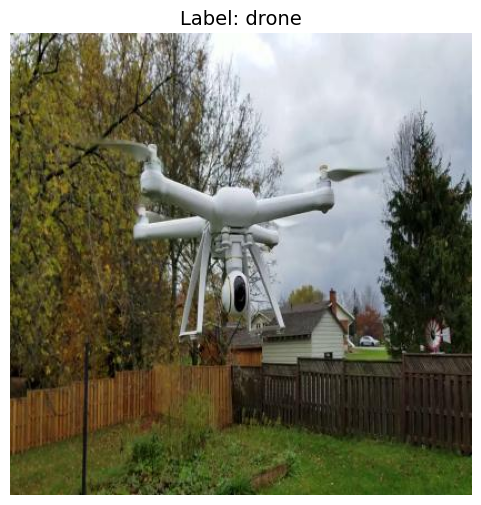

In [3]:
def show_random_image(root_dir):
    """
    Shows a random image and its label from the classification dataset.
    """
    all_images = []

    # collect images with their class labels
    for cls in os.listdir(root_dir):
        class_path = os.path.join(root_dir, cls)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
                    all_images.append((os.path.join(class_path, img_name), cls))

    if len(all_images) == 0:
        print("No images found in directory:", root_dir)
        return

    img_path, label = random.choice(all_images)
    img = Image.open(img_path)

    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.title(f"Label: {label}", fontsize=14)
    plt.axis("off")
    plt.show()

train_path = classifn_path / "train"
show_random_image(train_path)

In [4]:
def get_class_counts_classification(root_dir):
    splits = ["train", "valid", "test"]
    summary = {}
    for split in splits:
        split_dir = Path(root_dir) / split
        if not split_dir.exists():
            print(f"Warning: {split_dir} does not exist.")
            continue
        classes = [p for p in split_dir.iterdir() if p.is_dir()]
        counts = {}
        for c in classes:
            counts[c.name] = len(list((c).glob("*.jpg"))) + len(list((c).glob("*.png")))
        summary[split] = counts
    return summary

classif_counts = get_class_counts_classification(classifn_path)
classif_counts

{'train': {'bird': 1414, 'drone': 1248},
 'valid': {'bird': 217, 'drone': 225},
 'test': {'bird': 121, 'drone': 94}}

In [5]:
rows = []
for split, d in classif_counts.items():
    for cls, cnt in d.items():
        rows.append({"split": split, "class": cls, "count": cnt})

df_classif_counts = pd.DataFrame(rows)
display(df_classif_counts.pivot(index="class", columns="split", values="count").fillna(0).astype(int))
print("Per split total:\n", df_classif_counts.groupby("split")["count"].sum())

split,test,train,valid
class,,,
bird,121,1414,217
drone,94,1248,225


Per split total:
 split
test      215
train    2662
valid     442
Name: count, dtype: int64


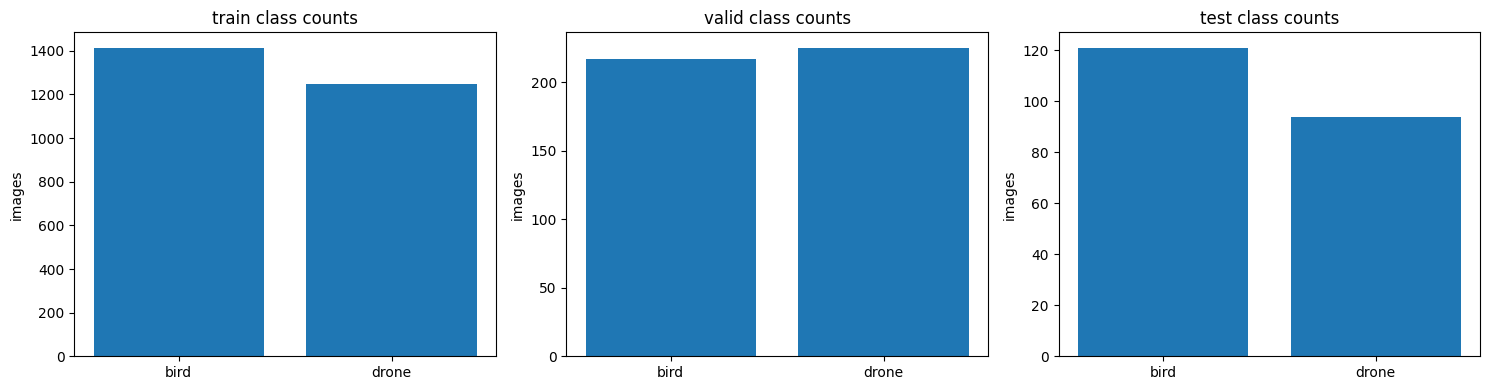

In [6]:
# class distribution per split
fig, axes = plt.subplots(1, 3, figsize=(15,4))
splits = ["train", "valid", "test"]
for ax, split in zip(axes, splits):
    data = df_classif_counts[df_classif_counts["split"]==split]
    ax.bar(data["class"], data["count"])
    ax.set_title(f"{split} class counts")
    ax.set_ylabel("images")
plt.tight_layout()
plt.show()

Equally distributed dataset

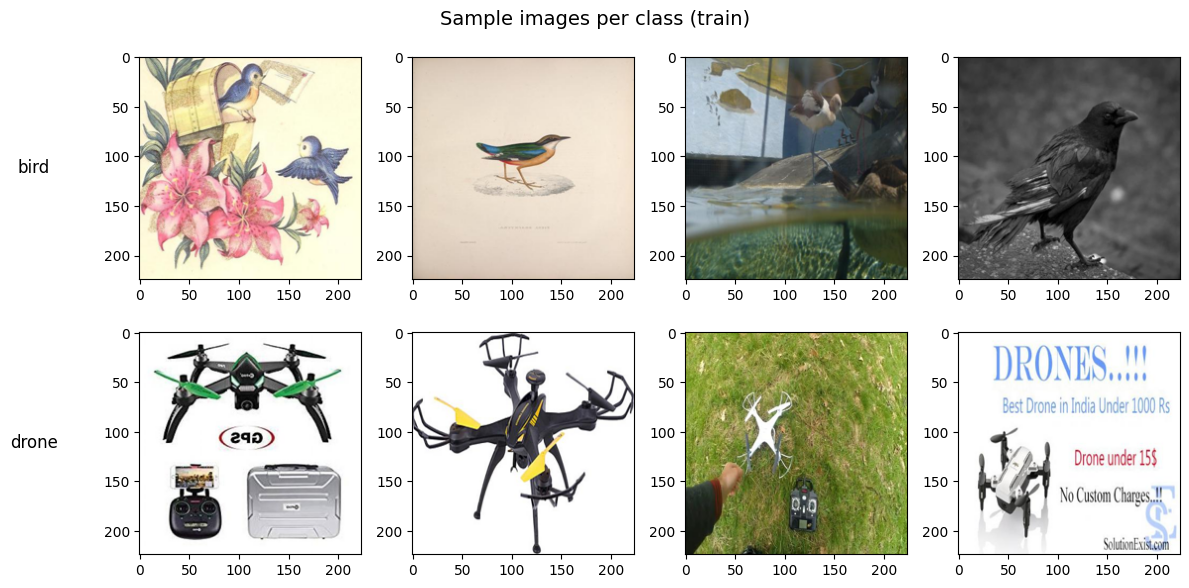

In [7]:
# visualize random sample images from each class 
def show_samples_classification(root_dir, n_per_class=4, img_size=(224,224)):
    train_dir = Path(root_dir) / "train"
    classes = [p.name for p in train_dir.iterdir() if p.is_dir()]
    fig, axs = plt.subplots(len(classes), n_per_class, figsize=(n_per_class*3, len(classes)*3))
    if axs.ndim == 1: axs = axs[np.newaxis, :]
    for i, cls in enumerate(classes):
        imgs = list((train_dir/cls).glob("*.jpg")) + list((train_dir/cls).glob("*.png"))
        imgs = sorted(imgs)
        if len(imgs) == 0:
            continue
        sample = random.sample(imgs, min(n_per_class, len(imgs)))
        for j in range(n_per_class):
            ax = axs[i, j] if axs.shape[0] > 1 else axs[j]
            if j < len(sample):
                img = Image.open(sample[j]).convert("RGB").resize(img_size)
                ax.imshow(img)
                if j==0:
                    ax.set_ylabel(cls, rotation=0, labelpad=50, fontsize=12, va="center")
            else:
                ax.set_facecolor((0.95,0.95,0.95))
    plt.suptitle("Sample images per class (train)", fontsize=14)
    plt.tight_layout()
    plt.show()

show_samples_classification(classifn_path, n_per_class=4, img_size=(224,224))

In [8]:
# image size stats (to check resizing strategy)
def get_image_size_stats(folder, n_sample=500):
    image_paths = []
    for ext in ("*.jpg", "*.png"):
        image_paths += list(Path(folder).rglob(ext))
    if len(image_paths) == 0:
        return {}
    sample = random.sample(image_paths, min(n_sample, len(image_paths)))
    sizes = [Image.open(p).size for p in sample]
    widths, heights = zip(*sizes)
    return {
        "num_images_total": len(image_paths),
        "sampled": len(sample),
        "width_mean": np.mean(widths),
        "width_median": np.median(widths),
        "height_mean": np.mean(heights),
        "height_median": np.median(heights),
        "min": (int(min(widths)), int(min(heights))),
        "max": (int(max(widths)), int(max(heights)))
    }

size_stats = get_image_size_stats(train_path)
size_stats

{'num_images_total': 2662,
 'sampled': 500,
 'width_mean': np.float64(416.0),
 'width_median': np.float64(416.0),
 'height_mean': np.float64(416.0),
 'height_median': np.float64(416.0),
 'min': (416, 416),
 'max': (416, 416)}

## Object detection YOLOv8 data

In [9]:
data_yaml_path = objdetn_path / "data.yaml"
if not data_yaml_path.exists():
    print("Warning: data.yaml not found at", data_yaml_path)
else:
    with open(data_yaml_path, 'r') as f:
        od_cfg = yaml.safe_load(f)
    print("Loaded data.yaml:\n", json.dumps(od_cfg, indent=2))

Loaded data.yaml:
 {
  "train": "../train/images",
  "val": "../valid/images",
  "test": "../test/images",
  "nc": 2,
  "names": [
    "Bird",
    "drone"
  ],
  "roboflow": {
    "workspace": "new-workspace-x00wt",
    "project": "drones-and-birds-0muie",
    "version": 1,
    "license": "CC BY 4.0",
    "url": "https://universe.roboflow.com/new-workspace-x00wt/drones-and-birds-0muie/dataset/1"
  }
}


In [10]:
def resolve_path(rel_path):
    if rel_path.startswith("/"):
        return Path(rel_path)
    if rel_path.startswith("../"):
        rel_path = rel_path[3:]
    return (data_yaml_path.parent / rel_path).resolve()

train_path_objd = resolve_path(od_cfg.get("train"))
val_path_objd   = resolve_path(od_cfg.get("val")) or None
test_path_objd  = resolve_path(od_cfg.get("test")) or None

print("Resolved train images dir:", train_path_objd)
print("Resolved val images dir:", val_path_objd)
print("Resolved test images dir:", test_path_objd)

Resolved train images dir: C:\Users\a_sur\Documents\Labmentix_Project_5_CV\datasets\object_detection_dataset\train\images
Resolved val images dir: C:\Users\a_sur\Documents\Labmentix_Project_5_CV\datasets\object_detection_dataset\valid\images
Resolved test images dir: C:\Users\a_sur\Documents\Labmentix_Project_5_CV\datasets\object_detection_dataset\test\images


In [11]:
def get_yolo_counts(images_dir):
    images = sorted(list(Path(images_dir).glob("**/*.jpg")) + list(Path(images_dir).glob("**/*.png")))
    labels_dir = Path(images_dir).parent / "labels" if (Path(images_dir)/"..").exists() else Path(images_dir).parent / "labels"
    labels = sorted(list((Path(images_dir).parent/"labels").glob("**/*.txt"))) if (Path(images_dir).parent/"labels").exists() else []

    return {
        "n_images": len(images),
        "n_labels": len(labels),
    }

train_counts = get_yolo_counts(train_path_objd)
val_counts = get_yolo_counts(val_path_objd)
test_counts = get_yolo_counts(test_path_objd)

print("Train counts:", train_counts)
print("Val counts:", val_counts)
print("Test counts:", test_counts)

Train counts: {'n_images': 2728, 'n_labels': 2728}
Val counts: {'n_images': 448, 'n_labels': 448}
Test counts: {'n_images': 224, 'n_labels': 224}


No missing labels

In [12]:
def parse_yolo_labels(images_dir):
    images = sorted(list(Path(images_dir).glob("**/*.jpg")) + list(Path(images_dir).glob("**/*.png")))
    labels_dir = Path(images_dir).parent / "labels"
    rows = []
    for img_path in images:
        label_path = labels_dir / (img_path.stem + ".txt")
        img_w, img_h = Image.open(img_path).size
        if not label_path.exists():
            continue
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                class_id, x_c, y_c, w, h = parts
                class_id = int(class_id)
                x_c, y_c, w, h = map(float, (x_c, y_c, w, h))
                # convert to absolute coords for area etc.
                abs_w = w * img_w
                abs_h = h * img_h
                area = abs_w * abs_h
                rows.append({
                    "image": str(img_path),
                    "label_file": str(label_path),
                    "class_id": class_id,
                    "x_center_rel": x_c, "y_center_rel": y_c,
                    "w_rel": w, "h_rel": h,
                    "w_abs": abs_w, "h_abs": abs_h,
                    "area": area,
                    "img_w": img_w, "img_h": img_h
                })
    return pd.DataFrame(rows)

df_train_ann = parse_yolo_labels(train_path_objd)
df_val_ann = parse_yolo_labels(val_path_objd)
df_test_ann = parse_yolo_labels(test_path_objd)

print("Train annotation rows:", len(df_train_ann))
print("Validation annotation rows:", len(df_val_ann))
print("Test annotation rows:", len(df_test_ann))

df_train_ann.head()

Train annotation rows: 3923
Validation annotation rows: 663
Test annotation rows: 273


,image,label_file,class_id,x_center_rel,y_center_rel,w_rel,h_rel,w_abs,h_abs,area,img_w,img_h
0,C:\Users\a_sur\Documents\Labmentix_Project_5_C...,C:\Users\a_sur\Documents\Labmentix_Project_5_C...,0,0.793269,0.318510,0.044471,0.027644,18.5,11.5,212.75,416,416
1,C:\Users\a_sur\Documents\Labmentix_Project_5_C...,C:\Users\a_sur\Documents\Labmentix_Project_5_C...,0,0.814904,0.292067,0.050481,0.024038,21.0,10.0,210.00,416,416
2,C:\Users\a_sur\Documents\Labmentix_Project_5_C...,C:\Users\a_sur\Documents\Labmentix_Project_5_C...,0,0.830529,0.263221,0.058894,0.032452,24.5,13.5,330.75,416,416
3,C:\Users\a_sur\Documents\Labmentix_Project_5_C...,C:\Users\a_sur\Documents\Labmentix_Project_5_C...,0,0.884615,0.263221,0.050481,0.039663,21.0,16.5,346.50,416,416
4,C:\Users\a_sur\Documents\Labmentix_Project_5_C...,C:\Users\a_sur\Documents\Labmentix_Project_5_C...,0,0.206731,0.318510,0.044471,0.027644,18.5,11.5,212.75,416,416


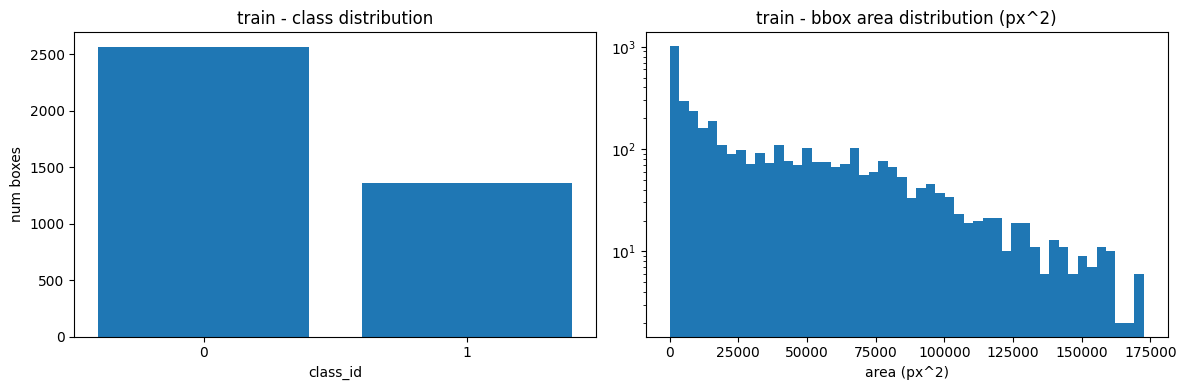

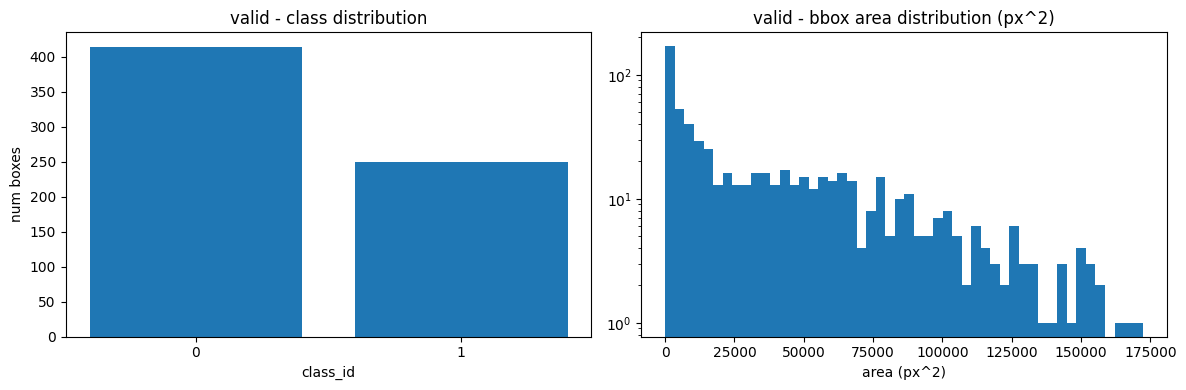

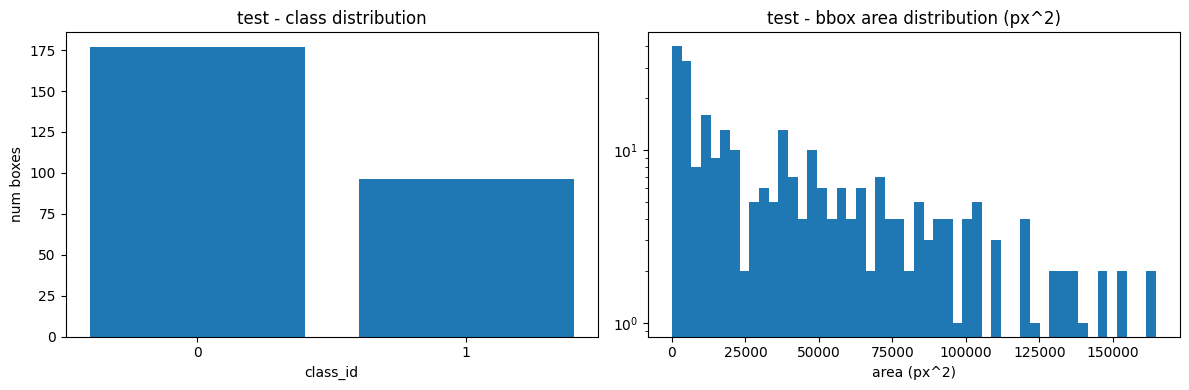

In [13]:
# YOLO annotation class distribution and bbox size distribution
def plot_detection_stats(df_ann, title="train"):
    if df_ann.empty:
        print(f"No annotation rows for {title}")
        return
    
    # class counts
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    cls_counts = df_ann["class_id"].value_counts().sort_index()
    axes[0].bar([str(i) for i in cls_counts.index], cls_counts.values)
    axes[0].set_title(f"{title} - class distribution")
    axes[0].set_xlabel("class_id")
    axes[0].set_ylabel("num boxes")

    # bbox area distribution (log scale)
    axes[1].hist(df_ann["area"], bins=50)
    axes[1].set_title(f"{title} - bbox area distribution (px^2)")
    axes[1].set_xlabel("area (px^2)")
    axes[1].set_yscale("log")
    plt.tight_layout()
    plt.show()

plot_detection_stats(df_train_ann, "train")
plot_detection_stats(df_val_ann, "valid")
plot_detection_stats(df_test_ann, "test")

Label 1 has fewer data points than label 0

In [14]:
# visualize
def draw_yolo_boxes_on_pil(img, bboxes, labels=None, label_names=None):
    """
    bboxes: list of dicts with keys: x_center_rel, y_center_rel, w_rel, h_rel, class_id
    """
    draw = ImageDraw.Draw(img)
    W, H = img.size
    font = ImageFont.load_default()
    
    for box in bboxes:
        xc = box["x_center_rel"] * W
        yc = box["y_center_rel"] * H
        w = box["w_rel"] * W
        h = box["h_rel"] * H
        x1 = xc - w/2
        y1 = yc - h/2
        x2 = xc + w/2
        y2 = yc + h/2
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
        lbl = f"{box['class_id']}" if label_names is None else (label_names[box['class_id']] if box['class_id'] < len(label_names) else str(box['class_id']))
        if font:
            draw.text((x1+3, y1+3), lbl, fill="yellow", font=font)
        else:
            draw.text((x1+3, y1+3), lbl, fill="yellow")
    return img

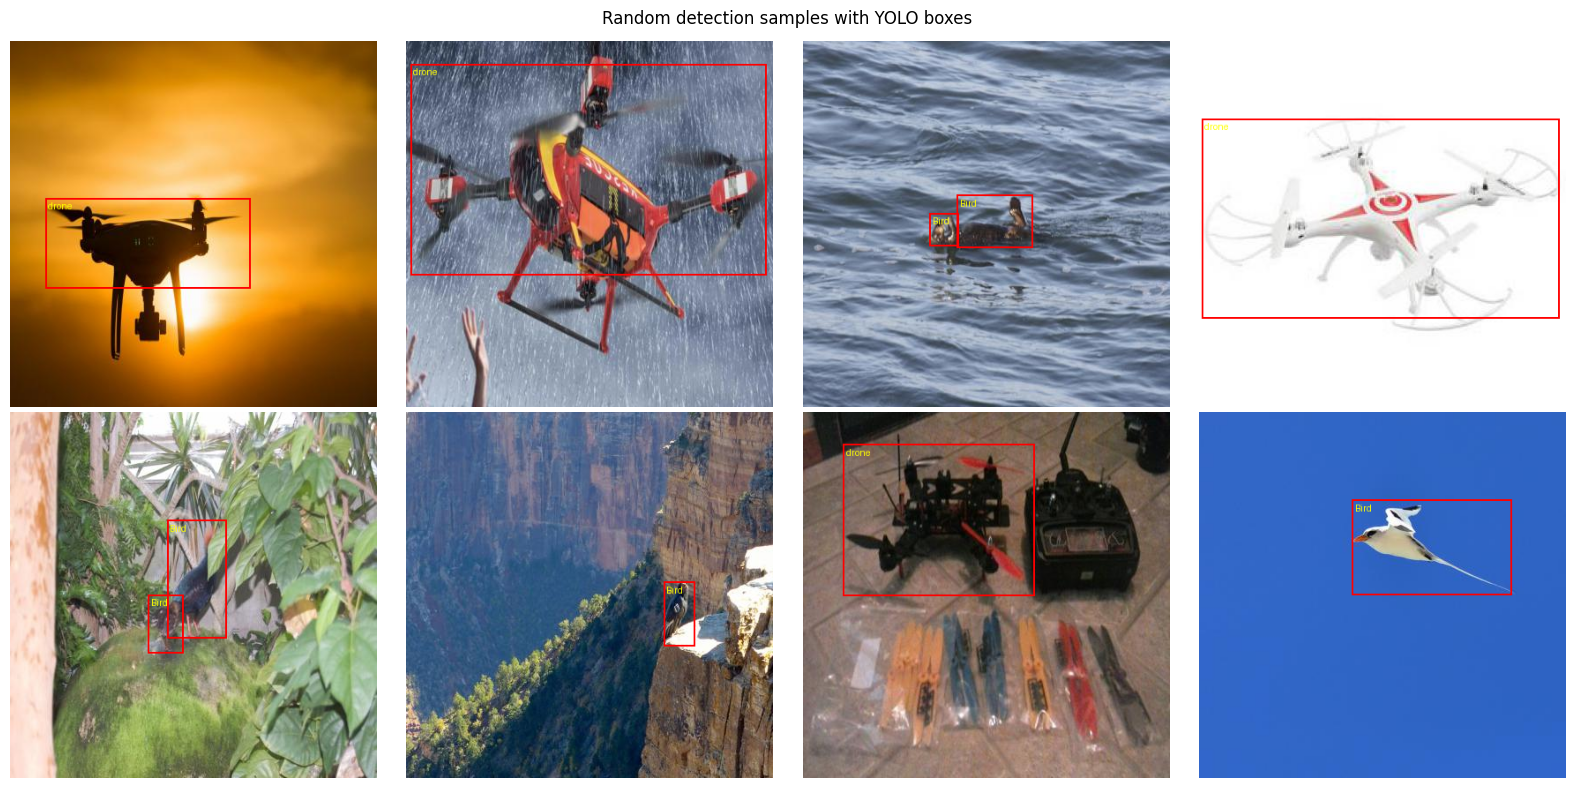

In [15]:
def show_random_detection_samples(images_dir, n=6, label_names=None):
    images = sorted(list(Path(images_dir).glob("**/*.jpg")) + list(Path(images_dir).glob("**/*.png")))
    if len(images)==0:
        print("No images found in", images_dir)
        return
    sample = random.sample(images, min(n, len(images)))
    fig = plt.figure(figsize=(16, 8))
    for i, img_path in enumerate(sample, start=1):
        pil = Image.open(img_path).convert("RGB")
        label_path = (img_path.parent.parent/"labels") / (img_path.stem + ".txt")
        bboxes = []
        if label_path.exists():
            with open(label_path, "r") as f:
                for line in f:
                    cls, xc, yc, w, h = line.strip().split()
                    bboxes.append({
                        "class_id": int(cls),
                        "x_center_rel": float(xc),
                        "y_center_rel": float(yc),
                        "w_rel": float(w),
                        "h_rel": float(h)
                    })
        ax = fig.add_subplot(2, math.ceil(n/2), i)
        ax.axis("off")
        img_boxes = draw_yolo_boxes_on_pil(pil.copy(), bboxes, label_names=label_names)
        ax.imshow(img_boxes)
    plt.suptitle("Random detection samples with YOLO boxes")
    plt.tight_layout()
    plt.show()

# If data.yaml contains names, use them
label_names = od_cfg.get("names", None)
show_random_detection_samples(train_path_objd, n=8, label_names=label_names)